In [1]:
import os, glob, csv, pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import SaltRemover
from collections import Counter, defaultdict

In [2]:
# first step need to read in the molecules and tokenize them and remove uncommon atoms
def get_unique_elements(smiles, salt_remover):
    try:
        mol = Chem.MolFromSmiles(smiles)
        mol = salt_remover.StripMol(mol)
        mol = max(Chem.GetMolFrags(mol, asMols=True), key=lambda m: m.GetNumAtoms())
        return set(atom.GetSymbol() for atom in mol.GetAtoms())
    except:
        return set()

salt_remover = SaltRemover.SaltRemover()
element_counter = Counter()

for chunk in tqdm(pd.read_csv("full_CSD.csv", chunksize=10000)):
    for smiles in chunk['Huckel_SMI']:
        unique_elements = get_unique_elements(smiles, salt_remover)
        element_counter.update(unique_elements)



0it [00:00, ?it/s][11:27:15] Unusual charge on atom 6 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 6 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 9 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 9 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 7 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 7 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 1 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 1 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 10 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 10 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 4 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 4 number of radical electrons set to zero
[11:27:15] Unusual charge on atom 7 number of radical electrons set 

In [6]:
total_num_mols = len(pd.read_csv("full_CSD.csv"))
allowed_elements = {element: count for element, count in element_counter.items() if count / total_num_mols > 0.001}
allowed_elements = set(allowed_elements)

In [9]:
disgarded_elements = set(element_counter) - allowed_elements
disgarded_elements

{'Ge', 'La'}

In [10]:
# clean up the salt form; keep the largest fragment; and remove the molecules with uncommon atoms
def process_tmc_smiles(input_csv_path, output_smiles_path, allowed_elements):
    df = pd.read_csv(input_csv_path)
    smiles_to_process = df['Huckel_SMI']
    failed_list = []
    
    with open(output_smiles_path, 'w') as f:
        for smi in tqdm(smiles_to_process):
            try:
                mol = Chem.MolFromSmiles(smi)
                mol = salt_remover.StripMol(mol)
                mol = max(Chem.GetMolFrags(mol, asMols=True), key=lambda m: m.GetNumAtoms())
                if set(atom.GetSymbol() for atom in mol.GetAtoms()) <= allowed_elements:
                    f.write(smi + '\n')
            except:
                failed_list.append(smi)
    
    pickle.dump(failed_list, open(output_smiles_path.replace('.smi', '_failed.pkl'), 'wb'))
    return
    

In [11]:
input_csv_path = "full_CSD.csv"
output_smiles_path = "full_CSD_clean.smi"
process_tmc_smiles(input_csv_path, output_smiles_path, allowed_elements)

  0%|          | 0/213096 [00:00<?, ?it/s][11:39:58] Unusual charge on atom 6 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 6 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 9 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 9 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 7 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 7 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 1 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 1 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 10 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 10 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 4 number of radical electrons set to zero
[11:39:58] Unusual charge on atom 4 number of radical electrons set to zero
  0%|          | 65/213096 [00:00<05:27, 649

In [12]:
failed_list = pickle.load(open(output_smiles_path.replace('.smi', '_failed.pkl'), 'rb'))
len(failed_list)

246

In [13]:
import random
# random splitting into train and validation sets
def split_train_val(input_smiles_path, output_folder, split_ratio=0.9):
    with open(input_smiles_path, 'r') as f:
        smiles_list = f.readlines()
    
    random.shuffle(smiles_list)
    split_index = int(len(smiles_list) * split_ratio)
    train_smiles = smiles_list[:split_index]
    val_smiles = smiles_list[split_index:]
    
    with open(os.path.join(output_folder, input_smiles_path.split('/')[-1].split('.')[0] + '_train.smi'), 'w') as f:
        for smi in train_smiles:
            f.write(smi)
    
    with open(os.path.join(output_folder, input_smiles_path.split('/')[-1].split('.')[0] + '_val.smi'), 'w') as f:
        for smi in val_smiles:
            f.write(smi)
            
    return

In [15]:
input_smiles_path = "full_CSD_clean.smi"
output_folder = "../tmc_test_run"
split_train_val(input_smiles_path, output_folder)

In [20]:
len(allowed_elements)

43

In [18]:
with open("full_CSD_clean.smi", "r") as f:
    smiles_list = f.readlines()

len(smiles_list), max(len(smi.strip()) for smi in smiles_list)


(212734, 504)

Text(0, 0.5, 'Frequency')

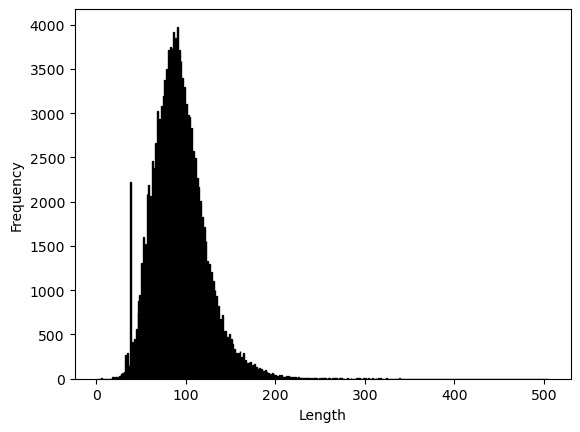

In [19]:
# plot the length distribution of the smiles
import matplotlib.pyplot as plt

lengths = [len(smi.strip()) for smi in smiles_list]
plt.hist(lengths, bins=range(1, max(lengths) + 2), edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')

## Training Scripts

```python
python molbert/apps/smiles.py \
    --train_file data/tmc_test_run/full_CSD_clean_train.smi \
    --valid_file data/tmc_test_run/full_CSD_clean_val.smi \
    --max_seq_length 256 \
    --batch_size 16 \
    --masked_lm 1 \
    --max_epochs 20 \
    --num_workers 4 \
    --val_check_interval 1\
    --fast_dev_run
```